# Import python packages

In [1]:
from gao import Gao

import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import random

np.random.seed(7)

# Define parameters and load bgp_routes and ToR datasets

Get path data

In [2]:
# from quickrib.main import QuickRIB
# import datetime

# quickrib = QuickRIB(
#     output_filename="bigconf",
#     output_folder="./data",
#     dump_res=datetime.timedelta(minutes=15),
#     start_time=datetime.datetime(2018, 3, 1),
#     end_time=datetime.datetime(2018, 3, 1),
#     collectors=["rrc04"],
# )

In [3]:
# import csv
# from quickrib.observers import PrefixBlockSizeObserver
# import json

# block_sizes = PrefixBlockSizeObserver()


# quickrib.intialize_processing()

# quickrib.build_rib()

# with open("small.pickle", "wb") as f:
#     pickle.dump(quickrib, file=f)

# with open("small.pickle", "rb") as f:
#     quickrib = pickle.load(f)
# with open("small_conf_paths.csv", "w") as f:
#     writer = csv.writer(f, quoting=csv.QUOTE_MINIMAL)

#     for bgpelem in quickrib.rib.iter_bgpelems():
#         paths = bgpelem.fields["as-path"]
#         block_size = block_sizes.get_block_size(bgpelem)

#         paths_str = json.dumps(paths)
#         writer.writerow([paths_str, block_size])


In [4]:
import csv
import json
import numpy as np
import pandas as pd

# Lists to accumulate
paths_list = []
block_sizes = []

# Open and read the CSV you wrote
with open("big_conf_paths.csv", newline="") as f:
    reader = csv.reader(f, quoting=csv.QUOTE_MINIMAL)
    for paths_str, blk in reader:
        # parse the JSON array of AS‑paths back into a Python list
        paths = json.loads(paths_str)
        paths_list.append(paths)
        block_sizes.append(int(blk))

# Convert into NumPy arrays
# - paths_array will be a 1-D array of Python lists
# - block_sizes_array will be a 1-D array of ints
paths_array = np.array(paths_list, dtype=object)
block_sizes_array = np.array(block_sizes, dtype=int)

# Example usage
print("Loaded", len(paths_array), "rows")
print("First AS‑path list:", paths_array[0])
print("First block size:", block_sizes_array[0])

Loaded 4753804 rows
First AS‑path list: ['513', '6730']
First block size: 0


In [5]:
ToR_MODEL_NAME = "CAIDA_s1_ToR_Classification_Gao"

TEST_SIZE = 0.2
# For some reason this does not match Gao definition
# This means the Gao will output this
# TOR_ORIG_LABELS_DICT = {"P2P": 0, "C2P": 1, "Siblings": 2, "P2C": 3}
# Authors manually remap Gao output later on. 
TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}
class_names = ['P2P', 'C2P', 'P2C']
DATA_PATH = '../'
MODELS_PATH = '../Models/'
RESULTS_PATH = '../Results/'


# bgp_routes = np.load(DATA_PATH + "bgp_routes_dataset.npy")
# bgp_routes_labels = np.load(DATA_PATH + "bgp_routes_labels.npy")
# print(bgp_routes.shape, bgp_routes_labels.shape)
bgp_routes = paths_array
print(bgp_routes.shape)

# This part uses Generate_Tor_Dataset to remap 0 (peers) and -1 (provider - customer) caida labels to our labels
DATA = "caida_s1_tor"
tor_dataset = np.load(DATA_PATH + DATA + "_dataset.npy")
tor_labels = np.load(DATA_PATH + DATA + "_labels.npy")

print(tor_dataset.shape, tor_labels.shape)

(4753804,)
(861840, 2) (861840,)


Distribution of GT labels

In [6]:
pd.Series(tor_labels).value_counts()

0    619648
3    121096
1    121096
dtype: int64

It looks like they need to be remapped!
from  
`{"P2P": 0, "C2P": 1, "Siblings": 2, "P2C": 3}`  
to  
`TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}`

In [7]:
for i, label in enumerate(tor_labels):
    if label == 3:
        tor_labels[i] = 2
pd.Series(tor_labels).value_counts()

0    619648
2    121096
1    121096
dtype: int64

In [8]:
def unique_asn(bgp_routes: np.ndarray):
    asns = set()
    for as_path in bgp_routes:
        for AS in as_path:
            asns.add(AS)
    return asns

topology_ASes = unique_asn(bgp_routes)
len(topology_ASes)

60124

In [9]:
def filter_tor(tor_dataset: np.ndarray, tor_labels: np.ndarray, topology_ASes: set):
    filtered_tor_dataset = []
    filtered_tor_labels = []

    for i in range(tor_dataset.shape[0]):
        as1, as2 = tor_dataset[i, :]
        if as1 not in topology_ASes:
            continue
        if as2 not in topology_ASes:
            continue
        
        filtered_tor_dataset.append([as1, as2])
        filtered_tor_labels.append(tor_labels[i])
        
    return np.asarray(filtered_tor_dataset), np.asarray(filtered_tor_labels)
        
tor_dataset, tor_labels = filter_tor(tor_dataset, tor_labels, topology_ASes)
print(tor_dataset.shape, tor_labels.shape)

(849774, 2) (849774,)


# Generate training and test sets
## Shauffle dataset

In [10]:
from sklearn.utils import shuffle
dataset, labels = shuffle(tor_dataset, tor_labels, random_state=7)

## Generate a balanced dataset

In [11]:
# def generate_balanced_dataset(dataset, labels, labels_set):
#     sets_dict = dict()
#     for label in labels_set:
#         sets_dict[label] = np.asarray([np.asarray(dataset[i]) for i in range(len(dataset)) if labels[i] == label])
    
#     min_set_len = min([len(label_set) for label_set in sets_dict.values()])
    
#     for label, label_set in sets_dict.iteritems():
#         sets_dict[label] = label_set[np.random.choice(label_set.shape[0], min_set_len, replace=False)]
    
#     dataset = np.concatenate((sets_dict.values()))
#     labels = []
#     for label, label_set in sets_dict.iteritems():
#         labels += [label]*len(label_set)
#         print label, len(label_set)
#     labels = np.asarray(labels)
#     return shuffle(dataset, labels, random_state=7)

# dataset, labels = generate_balanced_dataset(dataset, labels, (0,1,3))
# print dataset.shape, labels.shape

## Train Test Split

In [12]:
x_training, x_test, y_training, y_test = train_test_split(dataset, labels, test_size=TEST_SIZE)

del dataset, labels

# Run Gao Algorithm

In [13]:
gao = Gao(bgp_routes)

Finished __compute_as_degree
Finished __compute_as_transit_rank
Finished __assign_p2c_c2p_siblings_tors
Finished __identify_not_peering
Finished __assign_p2p_tors


# Final evaluation of the model
## Evaluate accuracy over the test set

In [14]:
y_test_prediction = gao.generate_labels_for_set(x_test)

display(pd.Series(y_test_prediction).value_counts())

# This part I add because Gao and authors labels dont match
# We need to remap Gaos output

# for i in range(len(y_test_prediction)):
#     if 


print(len(y_test_prediction))
y_test_prediction_new = []
for i in range(len(y_test_prediction)):
    if y_test_prediction[i] %2 == 0:
        y_test_prediction_new.append(0)
    elif y_test_prediction[i] == 3:
        y_test_prediction_new.append(2)
    else:
        y_test_prediction_new.append(1)

y_test_prediction_new = np.asarray(y_test_prediction_new)
print(len(y_test_prediction_new))
y_test_prediction = y_test_prediction_new

display(pd.Series(y_test_prediction).value_counts())

-1    125912
 3     21992
 1     21766
 2       202
 0        83
dtype: int64

169955
169955


1    147678
2     21992
0       285
dtype: int64

In [15]:
from sklearn.metrics import accuracy_score
test_scores = accuracy_score(y_test, y_test_prediction)
print("Accuracy: %.2f%%" % (test_scores*100))

Accuracy: 26.14%


In [16]:
x_test_cleaned = np.asarray([np.asarray(x_test[i]) for i in range(len(x_test)) if y_test_prediction[i] != -1])
y_test_cleaned = np.asarray([y_test[i] for i in range(len(y_test)) if y_test_prediction[i] != -1])
y_test_prediction_cleaned = np.asarray([y_test_prediction[i] for i in range(len(y_test_prediction)) if y_test_prediction[i] != -1])

In [17]:
print(len(x_test_cleaned), len(y_test_cleaned), len(y_test_prediction_cleaned))

169955 169955 169955


In [18]:
from sklearn.metrics import accuracy_score
test_scores = accuracy_score(y_test_cleaned, y_test_prediction_cleaned)
print("Accuracy: %.2f%%" % (test_scores*100))

Accuracy: 26.14%


## Test if by learning (asn1, asn2) -> p2c then (asn2, asn1) -> c2p and vice versa

In [19]:
# p2c = TOR_ORIG_LABELS_DICT['P2C']
# c2p = TOR_ORIG_LABELS_DICT['C2P']

# p2c_training = np.asarray([np.asarray(x_training[i]) for i in range(len(x_training)) if y_training[i] == p2c])
# p2c_training_oposite = np.asarray([np.asarray([pair[1], pair[0]]) for pair in p2c_training])
# p2c_training_labels = [p2c]*len(p2c_training)
# p2c_training_oposite_labels = [c2p]*len(p2c_training_oposite)
# print(p2c_training.shape, p2c_training_oposite.shape)

In [20]:
# p2c_training_labels_prediction = gao.generate_labels_for_set(p2c_training)
# p2c_training_scores = accuracy_score(p2c_training_labels, p2c_training_labels_prediction)
# print("Accuracy: %.2f%%" % (p2c_training_scores*100))

# p2c_training_oposite_labels_prediction = gao.generate_labels_for_set(p2c_training_oposite)
# p2c_training_oposite_scores = accuracy_score(p2c_training_oposite_labels, p2c_training_oposite_labels_prediction)
# print("Accuracy: %.2f%%" % (p2c_training_oposite_scores*100))

## Plot and save a confusion matrix for results over the test set

In [21]:
import pandas as pd


In [22]:
pd.Series(y_test).value_counts()

0    121960
2     24189
1     23806
dtype: int64

In [23]:
pd.Series(y_test_prediction).value_counts()

1    147678
2     21992
0       285
dtype: int64

### Define a function

In [24]:
%matplotlib inline

import matplotlib
import pylab as pl
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          fname='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, format(cm[i, j]*100, fmt) + '%',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")    
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(fname, bbox_inches='tight')

Confusion matrix, without normalization
Normalized confusion matrix


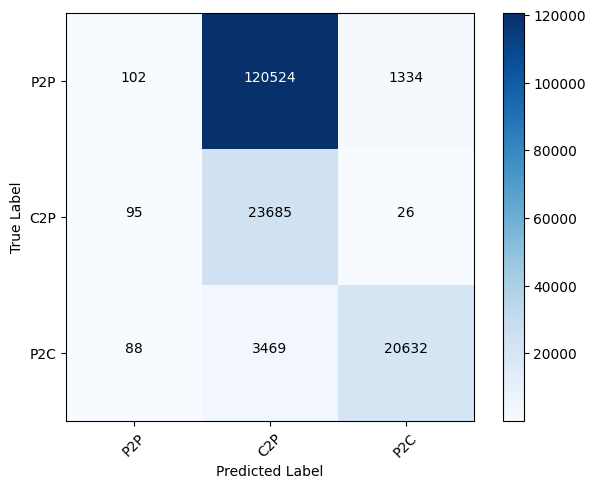

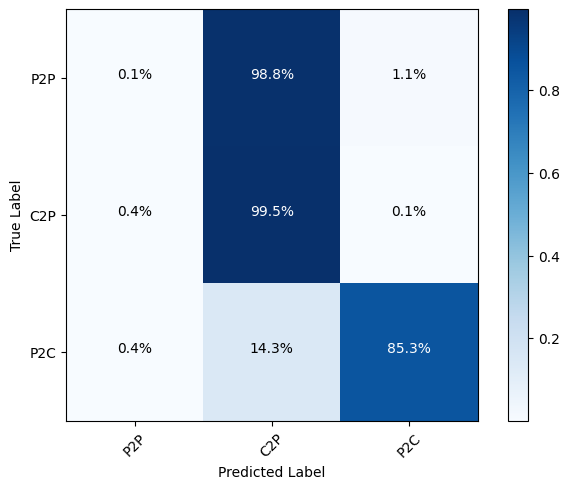

In [25]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      fname=RESULTS_PATH + ToR_MODEL_NAME + "_" + 'Confusion_matrix_without_normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized Confusion Msatrix',
                      fname=RESULTS_PATH +ToR_MODEL_NAME + "_" + 'Normalized_confusion_matrix')

plt.show()

# Export the model to a file

In [26]:
model_json = pairs_model.to_json()
with open(MODELS_PATH + ToR_MODEL_NAME + '.json', "w") as json_file:
    json_file.write(model_json)
pairs_model.save_weights(MODELS_PATH + ToR_MODEL_NAME + '.h5')
print("Save Model")

NameError: name 'pairs_model' is not defined

# Export results to a csv file (with original ASNs)
## Define functions

In [ ]:
def index2ASN(dataset_indexed, ASN_index_map):
    dataset = []
    index_ASN_map = {index: ASN for ASN, index in ASN_index_map.iteritems()}
    for row_indexed in dataset_indexed:
        row = []
        for index in row_indexed:
            if index != 0:
                row += [index_ASN_map[index]]
        dataset.append(row)
    
    return dataset

def index2ASN_labeled(dataset_indexed, labels_indexed, ASN_index_map):
    dataset = []
    index_ASN_map = {index: ASN for ASN, index in ASN_index_map.iteritems()}
    labels_colors_map = {0:'GREEN', 1:'RED'}
    
    for i, row_indexed in enumerate(dataset_indexed):
        row = []
        for index in row_indexed:
            if index != 0:
                row += [index_ASN_map[index]]
        row += [labels_colors_map[labels_indexed[i]]]
        dataset.append(row)
    
    return dataset

import csv
def export_csv(dataset, csv_name):
    with open(csv_name + '.csv', 'wb') as csv_file:
        csv_writer = csv.writer(csv_file)
        for row in dataset:
            csv_writer.writerow(row)

## Load a relevant dataset {all, misclassified, decided, undecided} and get model predictions

In [ ]:
### misclassified from the entire dataset ###

dataset = np.load(DATA_PATH + "bgp_routes_indexed_dataset.npy")
labels = np.load(DATA_PATH + "bgp_routes_labels.npy")

# remove UNDECIDED
dataset = np.asarray([np.asarray(dataset[i]) for i in range(len(dataset)) if labels[i] != 2])
labels = np.asarray([labels[i] for i in range(len(labels)) if labels[i] != 2])

# pad sequences
dataset = sequence.pad_sequences(dataset, maxlen=max_len)
# Get Model Predictions
predictions = model.predict_classes(dataset, verbose=1)

In [ ]:
# Create misclassified dataset
x_misclassified = np.asarray([route for i,route in enumerate(dataset) if labels[i] != predictions[i]])
y_misclassified_prediction = np.asarray([label for i,label in enumerate(predictions) if labels[i] != predictions[i]])
print len(x_misclassified), len(y_misclassified_prediction)

## Export Results

In [ ]:
dataset_misclassified = index2ASN_labeled(x_misclassified, y_misclassified_prediction, ASN_index_map)
export_csv(dataset_misclassified, RESULTS_PATH + MODEL_NAME + "_misclassified")